In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.geometry import Point

from tile_units import TileUnit
from tile_units import TileShape
from tile_map import Tiling

#### **LOL** I renamed your file to something more manageable... 
and added an ID column (so grab the one in the repo)

In [2]:
gwr = gpd.read_file("../data/lukes-gwr.gpkg").to_crs(5070)

# GWR example
## Make a H3 tile unit
First set the spacing (this is across the 7 hexes) and in whatever units the projection uses.

In [3]:
d = 50000


Make an empty tile unit we can overwrite with hand-made elements 

In [4]:
tile_unit = TileUnit(spacing = d, crs = gwr.crs, tile_shape = TileShape.HEXAGON)

In [5]:
# the basic H3 level to level scale factor and rotation
sf = 1 / np.sqrt(7)  
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

# inset scaling
sf2 = 0.9

hex = scale(tile_unit.tile.geometry[0], sf, sf)
corners = [p for p in hex.exterior.coords]
hex = rotate(hex, 30)
hexes = [hex] + [translate(
    hex, x * np.sqrt(3), y * np.sqrt(3)) for x, y in corners[:-1]]
hexes = gpd.GeoSeries(hexes, crs = gwr.crs).rotate(
    rotation, origin = (0, 0)).scale(sf2, sf2, origin = (0, 0))

tile_unit.elements = gpd.GeoDataFrame(
    data = {"element_id": list("abcdefg")}, crs = gwr.crs,
    geometry = hexes
)

Note that "a" is the centre one.

<AxesSubplot:>

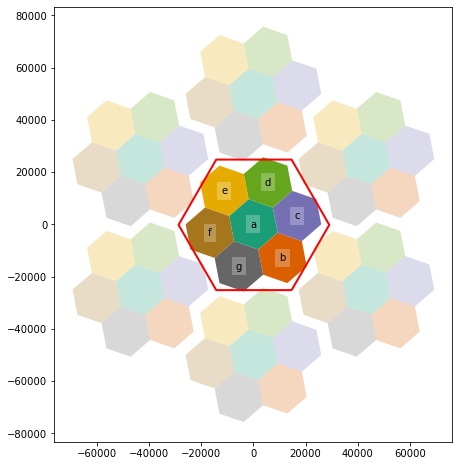

In [6]:
tile_unit.plot(r = 1)

## Tile a map

In [7]:
tiling = Tiling(tile_unit, gwr, id_var = "ID")
h3_map = tiling.get_tiled_map(prioritise_tiles = True)

## Some data reorganising
This is just to make things colourable with a named colour map.

In [8]:
betas = [n for n in gwr.columns if "beta_classified" in n]
beta_shortform = [n.replace("_beta_classified", "") for n in betas]

reclass = dict(zip(("associated with MORE covid", 
                    "not significant", 
                    "associated with LESS covid"), range(-1, 2)))

Use the reclass dictionary to make new data columns coded -1 0 1

In [9]:
for var, new_var in zip(betas, beta_shortform):
    gwr[var.replace("_beta_classified", "")] = \
        gwr[var].apply(lambda x: reclass[x])

## And make a map

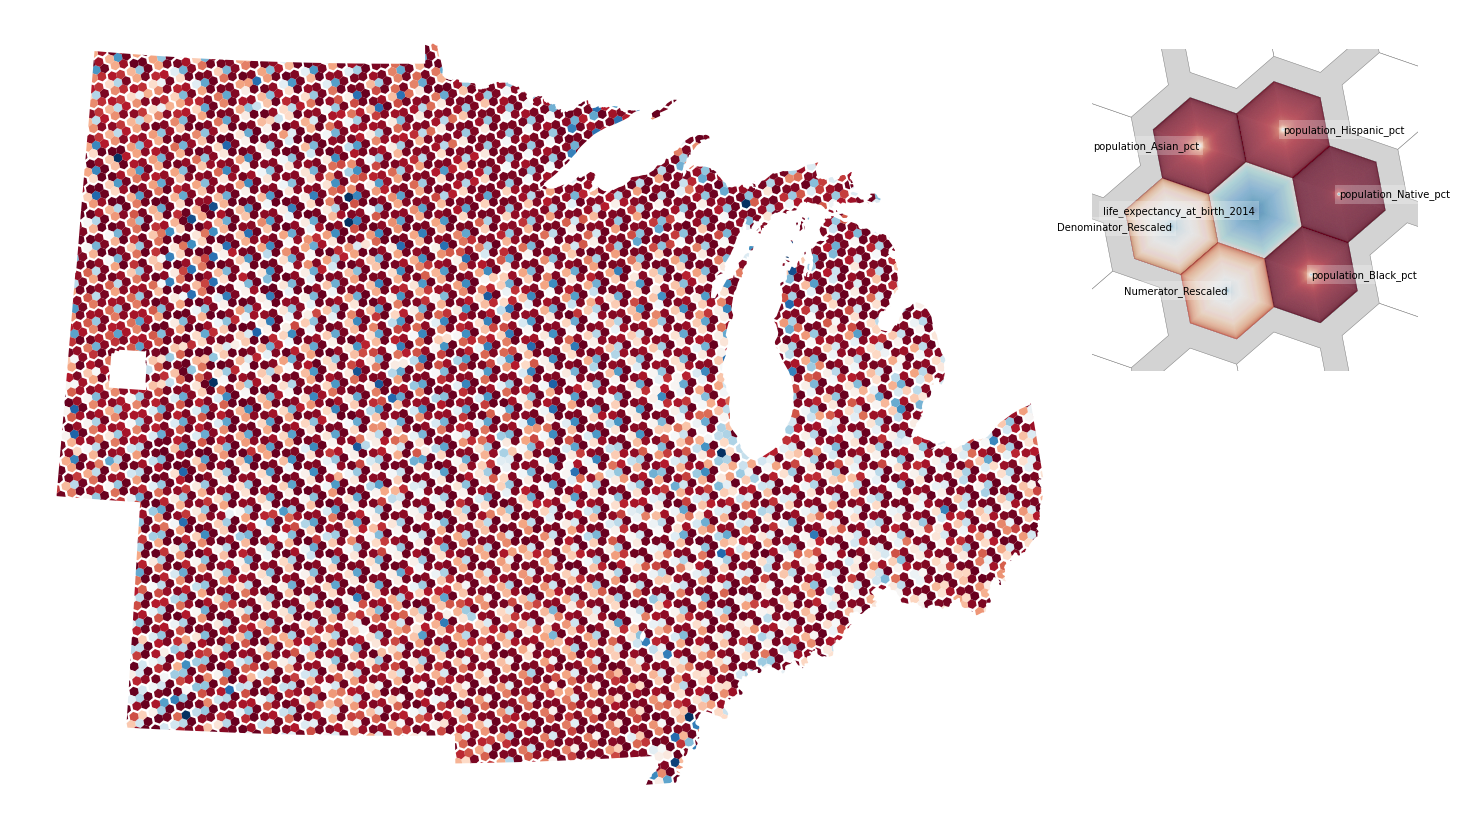

In [10]:
fig = pyplot.figure(figsize = (24, 15))

ids = list("bcdeafg")  # by inspection to get ordering desired

cols = dict(zip(ids, beta_shortform))
cmaps = dict(zip(ids, 7 * ["RdBu"]))

tiling.plot_map(fig, h3_map, cols, cmaps, legend = True)

You can write the GPKG out with `tiling_utils.write_map_to_layers(h3_map)`